In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

print(f"Train: {train_size}, Val: {val_size}, Test: {len(test_dataset)}")

Using device: cpu
Train: 48000, Val: 12000, Test: 10000


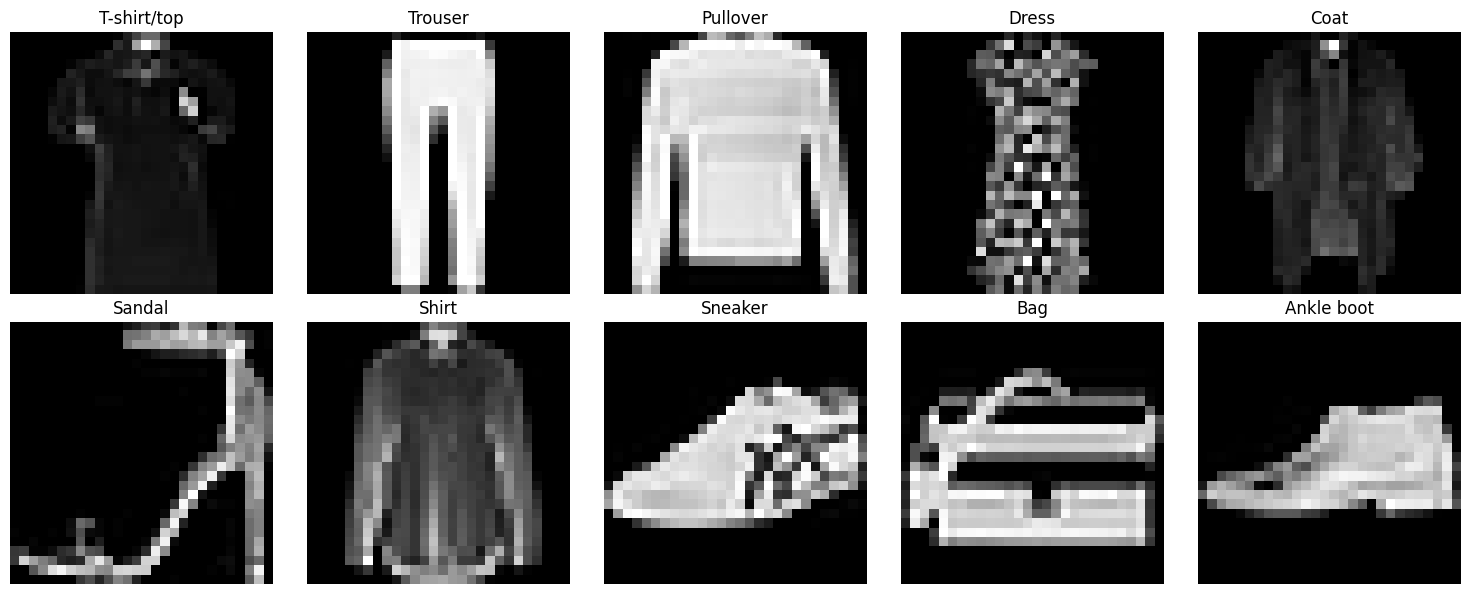

In [2]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
dataset = datasets.FashionMNIST(root='data', train=True, download=False, transform=None)
for i in range(10):
    indices = [idx for idx, (_, label) in enumerate(dataset) if label == i]
    idx = np.random.choice(indices)
    img, label = dataset[idx]
    axes[i // 5, i % 5].imshow(img, cmap='gray')
    axes[i // 5, i % 5].set_title(class_names[label])
    axes[i // 5, i % 5].axis('off')
plt.tight_layout()
plt.show()

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [4]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(15):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    if (epoch + 1) % 3 == 0:
        print(f"Epoch [{epoch+1}/15], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [3/15], Train Loss: 0.3474, Val Loss: 0.2803, Val Acc: 0.8938
Epoch [6/15], Train Loss: 0.2650, Val Loss: 0.2313, Val Acc: 0.9147
Epoch [9/15], Train Loss: 0.2198, Val Loss: 0.2230, Val Acc: 0.9173
Epoch [12/15], Train Loss: 0.1862, Val Loss: 0.2145, Val Acc: 0.9227
Epoch [15/15], Train Loss: 0.1569, Val Loss: 0.2175, Val Acc: 0.9218


In [5]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9170


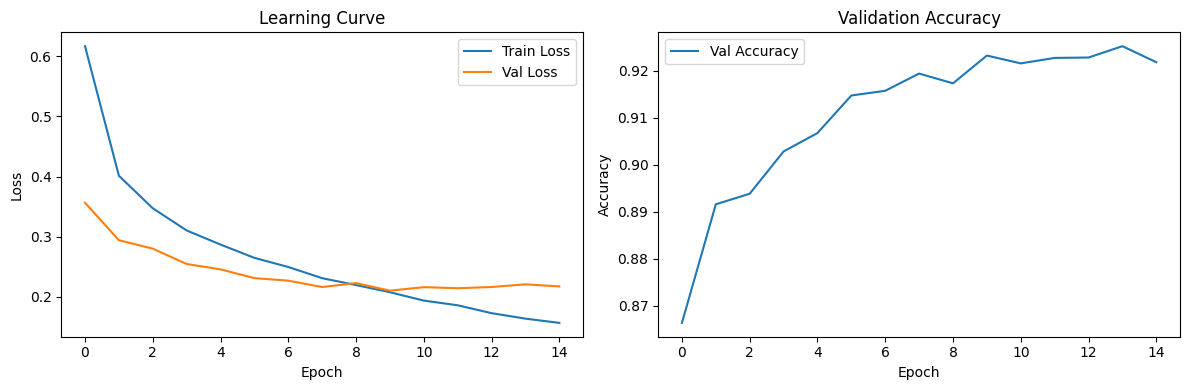

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Val Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Learning Curve')

ax[1].plot(val_accuracies, label='Val Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()

Predicted: Coat, Confidence: 0.7982


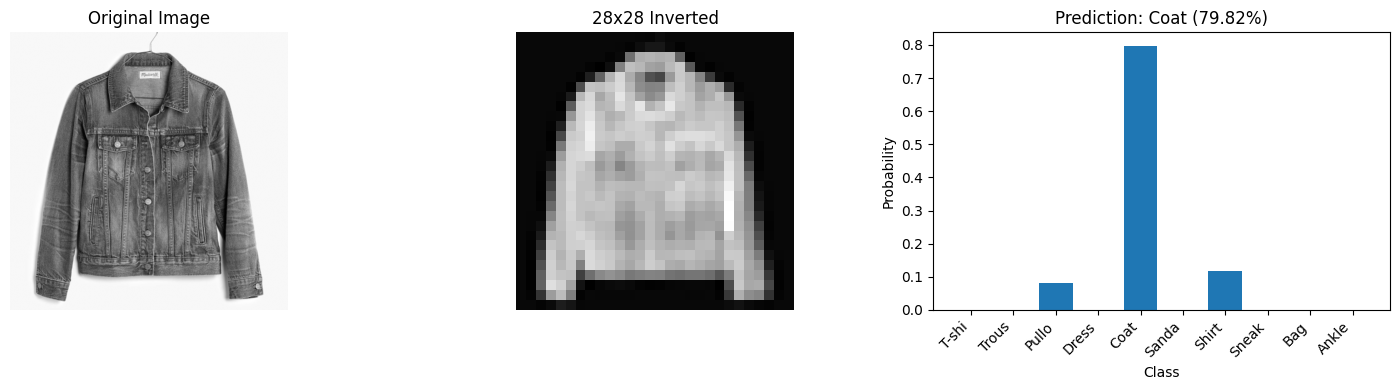

In [7]:
img_path = './my_fashion.png'
img_original = Image.open(img_path).convert('L')
img_resized = img_original.resize((28, 28))
img_inverted = ImageOps.invert(img_resized)
img_tensor = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])(img_inverted)
img_tensor = img_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
    probability = torch.softmax(output, 1)[0]
    predicted = torch.argmax(probability).item()
    confidence = probability[predicted].item()

print(f"Predicted: {class_names[predicted]}, Confidence: {confidence:.4f}")

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].imshow(img_original, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(img_inverted, cmap='gray')
ax[1].set_title(f'28x28 Inverted')
ax[1].axis('off')

ax[2].bar(range(10), probability.cpu().numpy())
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Probability')
ax[2].set_title(f'Prediction: {class_names[predicted]} ({confidence:.2%})')
ax[2].set_xticks(range(10))
ax[2].set_xticklabels([name[:5] for name in class_names], rotation=45, ha='right')

plt.tight_layout()
plt.show()